In [19]:
import sqlalchemy
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import pyodbc

In [73]:
northwind = create_engine('sqlite:///Northwind_larges.sqlite')
northwind

Engine(sqlite:///Northwind_larges.sqlite)

In [21]:
chinook = create_engine('sqlite:///chinook.db')


In [75]:
frameShips = pd.read_sql_query("""select ShipVia, ShipName, ShipAddress as ShipAdress, ShipCity, ShipRegion,
ShipPostalCode, ShipCountry from Orders;""", 
    con=northwind.connect())

In [99]:
frameCustomer = pd.read_sql_query("""select Id as Customer_ID, CompanyName, ContactName, Region, City, Country from Customer;""", 
    con=northwind.connect())

In [86]:
frameProduct = pd.read_sql_query("""select ProductName as Product_Name, UnitPrice, QuantityPerUnit, 
UnitsInStock as UnitslnStock, Discontinued, Category.CategoryName, Category.Description as DescriptionName
from Product inner join Category
on Product.CategoryId = Category.Id;""", 
    con=northwind.connect())

In [95]:
fecha_inicio='2009-01-01'
fecha_fin='2030-12-31'
dataFrameDate = pd.DataFrame({'fecha': pd.date_range(fecha_inicio, fecha_fin)})
dataFrameDate['anio'] = dataFrameDate.fecha.dt.year
dataFrameDate['mes'] = dataFrameDate.fecha.dt.month
dataFrameDate['dia'] = dataFrameDate.fecha.dt.day
dataFrameDate['nombredia'] = dataFrameDate.fecha.dt.day_name()
dataFrameDate['diasemana'] = dataFrameDate.fecha.dt.dayofweek
dataFrameDate['semana'] = dataFrameDate.fecha.dt.weekofyear
dataFrameDate['trimestre'] = dataFrameDate.fecha.dt.quarter
dataFrameDate = dataFrameDate[['fecha', 'anio', 'mes', 'dia', 'nombredia', 'diasemana', 'semana', 'trimestre']] 


C:\Users\zambr\AppData\Local\Temp/ipykernel_7260/104617120.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataFrameDate['semana'] = dataFrameDate.fecha.dt.weekofyear


In [62]:
dataFrameDate.to_sql(name='dim_times', con=northwind.connect(), if_exists='append',index=True)

In [61]:
frameShips.to_sql(name='dim_ships', con=northwind.connect(), if_exists='append',index=False)


In [51]:
Employee = pd.read_sql_query("""SELECT Employee.FirstName, Employee.LastName, Employee.Title, Employee.HireDate,Region.RegionDescription AS Region, Territory.TerritoryDescription AS Territory FROM Employee
INNER JOIN EmployeeTerritory
ON Employee.Id = EmployeeTerritory.EmployeeId
INNER JOIN Territory
ON Territory.Id = EmployeeTerritory.TerritoryId
INNER JOIN Region
ON Region.Id = Territory.RegionId """, con=northwind.connect())

In [102]:
frameOrderSales = pd.read_sql_query("""SELECT Customer.Id as Customer_ID, EmployeeId as Employee_ID, ProductId as Products_ID, 
dim_ships.Id as Ship_ID, Dim_Time.TimeId as Time_ID, Orders.OrderDate, Orders.RequiredDate, Orders.ShippedDate as ShipeDate, 
OrderDetail.UnitPrice, OrderDetail.Quantity,
OrderDetail.Discount, (OrderDetail.UnitPrice * OrderDetail.Quantity) - OrderDetail.Discount as Total
FROM Product INNER JOIN OrderDetail
ON Product.Id = OrderDetail.ProductId INNER JOIN Orders
on OrderDetail.OrderId = Orders.Id INNER JOIN Employee
on Orders.EmployeeId = Employee.Id INNER JOIN Customer
on Orders.CustomerId = Customer.Id INNER JOIN dim_ships
on Orders.Id = dim_ships.Id INNER JOIN Dim_Time
ON Orders.OrderDate = substr(dim_time.fecha,0,11)""", 
    con=northwind.connect())

In [96]:
frameShips.fillna(method="bfill", inplace = True) 
frameCustomer.fillna(method="bfill", inplace = True) 
frameProduct.fillna(method="bfill", inplace = True) 
Employee.fillna(method="bfill", inplace = True) 
frameOrderSales.fillna(method="bfill", inplace = True) 
dataFrameDate.fillna(method="bfill", inplace = True) 

In [104]:
engine = sqlalchemy.create_engine('mssql+pyodbc://localhost/ESQUEMAESTRELLA3?driver=SQL+Server+Native+Client+11.0')
try:     
    frameShips.to_sql(name='Dim_Ship', con=engine, if_exists='append',index=False)
    frameCustomer.to_sql('Dim_Customer', con=engine, if_exists='append',index=False)
    frameProduct.to_sql('Dim_Products', con=engine, if_exists='append',index=False)
    Employee.to_sql('Dim_Employee', con=engine, if_exists='append',index=False)
    dataFrameDate.to_sql('Dim_Time', con=engine, if_exists='append',index=False)
    frameOrderSales.to_sql('Sales_Order', con=engine, if_exists='append',index=False)
except Exception as ex:
                 print("Ocurrió un error: {}".format(ex))

In [107]:
import matplotlib.pyplot as plt

In [105]:
def conexion():
    try:
        connection = pyodbc.connect('DRIVER={SQL Server};SERVER=LOCALHOST;DATABASE=ESQUEMAESTRELLA3;UID='';PWD='' ')
        print("Extracción Exitosa")
    except Exception as ex:
    
        print("Ocurrió un error: {}".format(ex))
                
    return connection

In [106]:
ProductosMasVendidos = pd.read_sql_query("""select top 20 Dim_Products.Product_Name, SUM(Sales_Order.Total) as "Cantidad_Vendida" from Sales_Order inner join Dim_Products
on Sales_Order.Products_ID = Dim_Products.Product_ID
group by Dim_Products.Product_Name
order by SUM(Sales_Order.Total) desc""",conexion())

Extracción Exitosa


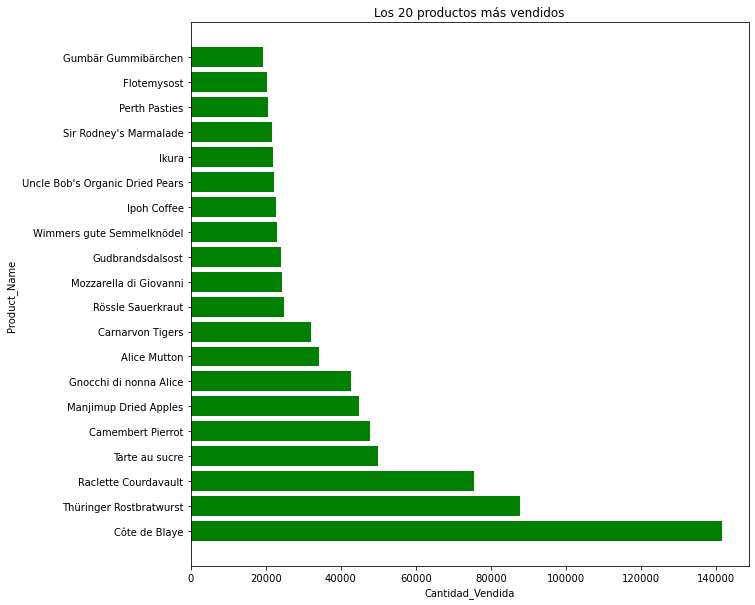

In [108]:
columna1=ProductosMasVendidos['Product_Name']
columna1
columna2=ProductosMasVendidos['Cantidad_Vendida']
plt.figure(figsize=(10,10))
plt.barh(columna1, columna2, color="green")
## Legenda en el eje y
plt.ylabel('Product_Name ')
## Legenda en el eje x
plt.xlabel('Cantidad_Vendida')
plt.title('Los 20 productos más vendidos')
plt.savefig('ProductName_CantidadVendida.png')
plt.show()

In [109]:
CompañiasMasCompras = pd.read_sql_query("""select top 10 Dim_Customer.CompanyName, SUM(Sales_Order.Total) as "Compras_totales" from Sales_Order inner join Dim_Customer
on Sales_Order.Customer_ID = Dim_Customer.Customer_ID
group by Dim_Customer.CompanyName
order by SUM(Sales_Order.Total) desc""",conexion())

Extracción Exitosa


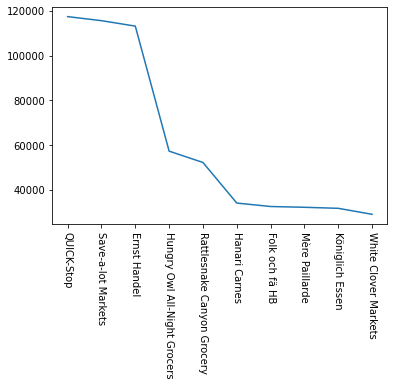

In [110]:
x = CompañiasMasCompras['CompanyName']

y = CompañiasMasCompras['Compras_totales']
fig, ax = plt.subplots()
#Creamos la Grafica
ax.plot(x, y)
plt.xticks(rotation = 270)
plt.savefig('10Compañias_conMas_Compras.png')
plt.show()

In [111]:
AñoOrdenCompra = pd.read_sql_query("""select DATEPART(YEAR,Sales_Order.OrderDate) as "Año_de_Orden", 
SUM(Sales_Order.Total) as "Total"
from Sales_Order inner join Dim_Time
on Sales_Order.Time_ID = Dim_Time.Time_ID
group by DATEPART(YEAR,Sales_Order.OrderDate)
order by SUM(Sales_Order.Total) desc""",conexion())

Extracción Exitosa


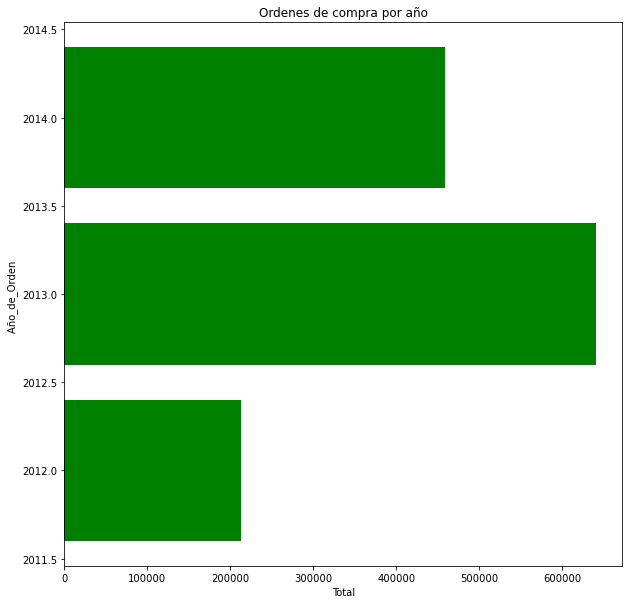

In [112]:
columna1=AñoOrdenCompra['Año_de_Orden']
columna1
columna2=AñoOrdenCompra['Total']
plt.figure(figsize=(10,10))
plt.barh(columna1, columna2, color="green")
## Legenda en el eje y
plt.ylabel('Año_de_Orden ')
## Legenda en el eje x
plt.xlabel('Total')
plt.title('Ordenes de compra por año')
plt.savefig('Ordenes_de_compra_por_año.png')
plt.show()